In [2]:
import pylab as pl
import numpy as np
from scipy import integrate
from scipy.integrate import odeint
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']

## 数值积分-integrate

### 球的体积

In [3]:
def half_circle(x):
    return (1-x**2)**0.5

In [4]:
N = 10000
x = np.linspace(-1, 1, N)
dx = x[1] - x[0]
y = half_circle(x)
2 * dx * np.sum(y) # 面积的两倍 

3.1415893269307373

In [5]:
np.trapz(y, x) * 2 # 面积的两倍

3.1415893269315975

In [6]:
from scipy import integrate
pi_half, err = integrate.quad(half_circle, -1, 1)
pi_half * 2

3.141592653589797

In [7]:
def half_sphere(x, y):
    return (1-x**2-y**2)**0.5

In [9]:
volume, error = integrate.dblquad(half_sphere, -1, 1, 
        lambda x:-half_circle(x), 
        lambda x:half_circle(x))

print (volume, error, np.pi*4/3/2)

2.094395102393199 1.0002356720661965e-09 2.0943951023931953


### 解常微分方程组

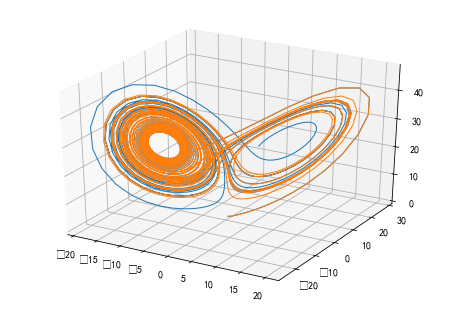

In [10]:
#%fig=洛伦茨吸引子：微小的初值差别也会显著地影响运动轨迹
from scipy.integrate import odeint 
import numpy as np 

def lorenz(w, t, p, r, b): #❶
    # 给出位置矢量w，和三个参数p, r, b计算出
    # dx/dt, dy/dt, dz/dt的值
    x, y, z = w.tolist()
    # 直接与lorenz的计算公式对应 
    return p*(y-x), x*(r-z)-y, x*y-b*z

t = np.arange(0, 30, 0.02) # 创建时间点 
# 调用ode对lorenz进行求解, 用两个不同的初始值 
track1 = odeint(lorenz, (0.0, 1.00, 0.0), t, args=(10.0, 28.0, 3.0)) #❷
track2 = odeint(lorenz, (0.0, 1.01, 0.0), t, args=(10.0, 28.0, 3.0)) #❸
#%hide
from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure()
ax = Axes3D(fig)
ax.plot(track1[:,0], track1[:,1], track1[:,2], lw=1)
ax.plot(track2[:,0], track2[:,1], track2[:,2], lw=1);

### ode类

In [11]:
def mass_spring_damper(xu, t, m, k, b, F):
    x, u = xu.tolist()
    dx = u
    du = (F - k*x - b*u)/m
    return dx, du 

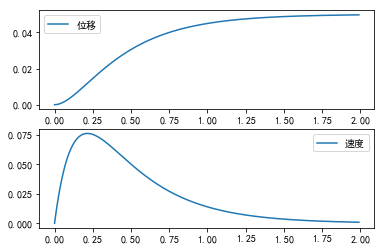

In [12]:
#%fig=滑块的速度和位移曲线
m, b, k, F = 1.0, 10.0, 20.0, 1.0
init_status = 0.0, 0.0
args = m, k, b, F
t = np.arange(0, 2, 0.01)
result = odeint(mass_spring_damper, init_status, t, args)
#%hide
fig, (ax1, ax2) = pl.subplots(2, 1)
ax1.plot(t, result[:, 0], label=u"位移")
ax1.legend()
ax2.plot(t, result[:, 1], label=u"速度")
ax2.legend();

In [13]:
from scipy.integrate import ode

class MassSpringDamper(object): #❶
    
    def __init__(self, m, k, b, F):
        self.m, self.k, self.b, self.F = m, k, b, F
        
    def f(self, t, xu):
        x, u = xu.tolist()
        dx = u
        du = (self.F - self.k*x - self.b*u)/self.m
        return [dx, du] 

system = MassSpringDamper(m=m, k=k, b=b, F=F)
init_status = 0.0, 0.0
dt = 0.01

r = ode(system.f) #❷
r.set_integrator('vode', method='bdf')
r.set_initial_value(init_status, 0)

t = []
result2 = [init_status]
while r.successful() and r.t + dt < 2: #❸
    r.integrate(r.t + dt)
    t.append(r.t)
    result2.append(r.y)
    
result2 = np.array(result2)
np.allclose(result, result2)

True

In [14]:
class PID(object):
    
    def __init__(self, kp, ki, kd, dt):
        self.kp, self.ki, self.kd, self.dt = kp, ki, kd, dt
        self.last_error = None
        self.status = 0.0
        
    def update(self, error):
        p = self.kp * error
        i = self.ki * self.status
        if self.last_error is None:
            d = 0.0
        else:
            d = self.kd * (error - self.last_error) / self.dt
        self.status += error * self.dt
        self.last_error = error
        return p + i + d

控制力的终值: 19.943404699515057


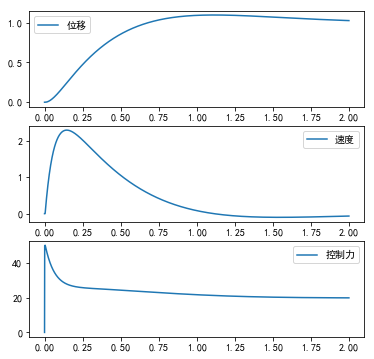

In [16]:
#%fig=使用PID控制器让滑块停在位移为1.0处
def pid_control_system(kp, ki, kd, dt, target=1.0):
    system = MassSpringDamper(m=m, k=k, b=b, F=0.0)
    pid = PID(kp, ki, kd, dt)
    init_status = 0.0, 0.0

    r = ode(system.f)
    r.set_integrator('vode', method='bdf')
    r.set_initial_value(init_status, 0)

    t = [0]
    result = [init_status]
    F_arr = [0]

    while r.successful() and r.t + dt < 2.0:
        r.integrate(r.t + dt)
        err = target - r.y[0]  #❶
        F = pid.update(err)  #❷
        system.F = F  #❸
        t.append(r.t)
        result.append(r.y)
        F_arr.append(F)

    result = np.array(result)
    t = np.array(t)
    F_arr = np.array(F_arr)
    return t, F_arr, result


t, F_arr, result = pid_control_system(50.0, 100.0, 10.0, 0.001)
print(u"控制力的终值:", F_arr[-1])
#%hide
fig, (ax1, ax2, ax3) = pl.subplots(3, 1, figsize=(6, 6))
ax1.plot(t, result[:, 0], label=u"位移")
ax1.legend(loc="best")
ax2.plot(t, result[:, 1], label=u"速度")
ax2.legend(loc="best")
ax3.plot(t, F_arr, label=u"控制力")
ax3.legend(loc="best")

In [17]:
%%time
from scipy import optimize


def eval_func(k):
    kp, ki, kd = k
    t, F_arr, result = pid_control_system(kp, ki, kd, 0.01)
    return np.sum(np.abs(result[:, 0] - 1.0))


kwargs = {
    "method": "L-BFGS-B",
    "bounds": [(10, 200), (10, 100), (1, 100)],
    "options": {
        "approx_grad": True
    }
}

opt_k = optimize.basinhopping(
    eval_func, (10, 10, 10), niter=10, minimizer_kwargs=kwargs)
print(opt_k.x)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_basinhopping.py:282: OptimizeWarning: Unknown solver options: approx_grad
  return self.minimizer(self.func, x0, **self.kwargs)


[56.67106149 99.97434757  1.33963577]
Wall time: 55.1 s


t=0.5000000000000002, x=1.07098, u=0.315352


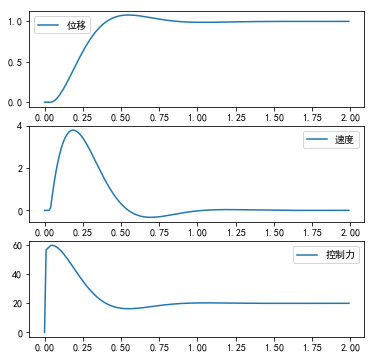

In [18]:
#%fig=优化PID的参数降低控制响应时间
kp, ki, kd = opt_k.x
t, F_arr, result = pid_control_system(kp, ki, kd, 0.01)
idx = np.argmin(np.abs(t - 0.5))
x, u = result[idx]
print ("t={}, x={:g}, u={:g}".format(t[idx], x, u))
#%hide
fig, (ax1, ax2, ax3) = pl.subplots(3, 1, figsize=(6, 6))
ax1.plot(t, result[:, 0], label=u"位移")
ax1.legend(loc="best")
ax2.plot(t, result[:, 1], label=u"速度")
ax2.legend(loc="best")
ax3.plot(t, F_arr, label=u"控制力")
ax3.legend(loc="best");